# Portfolio Optimization with genetic algorithm

### Libraries

In [115]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import matplotlib as mpl
import time
from matplotlib import cm


## 1. Data preparation 
 Download the ETF price data from Yahoo Finance and calculate daily log returns
 - Data source is from yahoo finance.  
 - Universe is  [GICS Sector Index ETF] Instrument  
 - Benchmark  [SPY] & Lookback window  

### 1.1 Universe Definition

In [116]:
universe = {
  'VDE' : "Energy",
  'VAW' : 'Materials',
  'VIS' : 'Industrial',
  'VCR' : 'Consumer&Discretionary',
  'VDC' :  'Consumer Staples',
  'VHT' :  'Health Care',
  'VFH' :  'Financials',
  'VGT' :  'Information Technology',
  'VOX' :  'Communication Services',
  'VPU' :  'Utilities Sector',
  'VNQ' :  'Real Estate',
    
}
tickers = list(universe.keys())
print(tickers)

['VDE', 'VAW', 'VIS', 'VCR', 'VDC', 'VHT', 'VFH', 'VGT', 'VOX', 'VPU', 'VNQ']


### 1.2 Data Download and calculate daily log returns

In [117]:
# SPY benchmark
df_bm = yf.download(tickers="SPY", start="2006-01-01", end="2022-12-31", repair=True)
df_bm = df_bm.drop(columns=['Repaired?'])
df_bm_return = np.log(df_bm/df_bm.shift(1)).dropna()


# Sector ETF 
df_ohlcv = yf.download(tickers=' '.join(tickers), start="2006-01-01", end="2022-12-31", repair=True)
df_close = df_ohlcv['Adj Close']
df_return = np.log(df_close/df_close.shift(1)).dropna()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  11 of 11 completed


### 1.3 Descriptive Statistics 

In [118]:
df_bm_return['Adj Close'].describe()

count    4278.000000
mean        0.000336
std         0.012622
min        -0.115887
25%        -0.004088
50%         0.000653
75%         0.005877
max         0.135577
Name: Adj Close, dtype: float64

In [119]:
df_return.describe()

,VAW,VCR,VDC,VDE,VFH,VGT,VHT,VIS,VNQ,VOX,VPU
count,4278.000000,4278.000000,4278.000000,4278.000000,4278.000000,4278.000000,4278.000000,4278.000000,4278.000000,4278.000000,4278.000000
mean,0.000313,0.000379,0.000380,0.000205,0.000174,0.000471,0.000411,0.000332,0.000239,0.000187,0.000328
std,0.015931,0.014318,0.009365,0.019861,0.018419,0.014600,0.011274,0.014267,0.019478,0.013506,0.012058
min,-0.131296,-0.139627,-0.098099,-0.220964,-0.176517,-0.144868,-0.117131,-0.121729,-0.217084,-0.121260,-0.119072
25%,-0.006732,-0.005524,-0.003750,-0.008524,-0.006628,-0.005742,-0.004628,-0.005514,-0.006633,-0.005811,-0.004996
50%,0.000893,0.001077,0.000700,0.000496,0.000662,0.001186,0.000752,0.000995,0.000826,0.000867,0.000900
75%,0.008201,0.007124,0.004934,0.009964,0.007413,0.007535,0.006294,0.007015,0.007659,0.006792,0.006210
max,0.111807,0.104914,0.086540,0.157835,0.149071,0.104486,0.111397,0.112485,0.157059,0.130786,0.122263


## 2. Parameter & Fitness Calculations


In [155]:
def validate_and_handle_errors(func):
    """
    A decorator function for validating inputs and handling errors.
    """
    def wrapper(x, avg_days=252):
        # Validate the inputs
        assert isinstance(x, (list, pd.Series, pd.DataFrame)), "x must be a list, a pandas Series, or a pandas DataFrame"
        assert isinstance(avg_days, int), "avg_days must be an integer"
        assert avg_days > 0, "avg_days must be positive"
        assert len(x) > 0, "x must not be empty"
        
        try:
            # Call the decorated function
            return func(x, avg_days)
        except ZeroDivisionError:
            print("Division by zero error! The input list or DataFrame x is empty.")
            return None
        except Exception as e:
            print(f"An error occurred: {e}")
            return None

    return wrapper

In [157]:
def validate_and_handle_errors_sharp(func):
    """
    A decorator function for validating inputs and handling errors for sharpe ratio functions.
    """
    def wrapper(mu, sigma, rf=0.05):
        # Validate the inputs
        assert isinstance(mu, (int, float)), "mu must be a number"
        assert isinstance(sigma, (int, float)), "sigma must be a number"
        assert isinstance(rf, (int, float)), "rf must be a number"
        assert sigma > 0, "sigma must be positive (greater than zero)"
        
        try:
            # Call the decorated function
            return func(mu, sigma, rf)
        except ZeroDivisionError:
            print("Division by zero error! Sigma (standard deviation) should not be zero.")
            return None
        except Exception as e:
            print(f"An error occurred: {e}")
            return None

    return wrapper

In [158]:
@validate_and_handle_errors
def CAGR(x, avg_days=252):
    """
    The function calculates the Compound Annual Growth Rate (CAGR), which is a measure of the mean annual growth rate 
    of an investment over a specified time period. The function assumes that the investment is compounded over the 
    time period.
    
    Parameters:
    x: pandas Series or list of daily log returns
    avg_days: int, optional (default = 252). This represents the average number of trading days in a year. The standard 
              in the industry is 252 days.
    
    Returns:
    float: The Compound Annual Growth Rate (CAGR) of the investment.
    """
    total_growth = np.exp(np.sum(x))
    year_fraction = avg_days / len(x)
    annual_growth = total_growth ** year_fraction
    return annual_growth - 1

In [159]:
@validate_and_handle_errors
def annualized_variance(x, avg_days=252):
    """
    The function calculates the annualized variance of an investment, which is a measure of the mean annual fluctuation 
    in the log returns over a specified time period.
    
    Parameters:
    x: pandas Series or list of daily log returns
    avg_days: int, optional (default = 252). This represents the average number of trading days in a year. The standard 
              in the industry is 252 days.
    
    Returns:
    float: The annualized variance of the investment.
    """
    daily_std_dev = np.std(x)
    daily_variance = daily_std_dev ** 2
    return daily_variance * avg_days

In [160]:
@validate_and_handle_errors
def annualized_covariance(x, avg_days=252):
    """
    The function calculates the annualized covariance matrix of a portfolio of investments, 
    which is a measure of how the returns of the different investments move together over a specified time period.
    
    Parameters:
    x: pandas DataFrame of daily log returns
    avg_days: int, optional (default = 252). This represents the average number of trading days in a year. The standard 
              in the industry is 252 days.
    
    Returns:
    pandas DataFrame: The annualized covariance matrix of the investments.
    """
    daily_covariance_matrix = x.cov()
    return daily_covariance_matrix * avg_days
 

In [171]:

def pf_CAGR(cagrs, weights, cov=None):
    """
    The function calculates the CAGR of a weighted portfolio of investments. 

    Parameters:
    cagrs: numpy array of CAGRs for each investment
    weights: numpy array of weights for each investment. The weights represent the proportion of the portfolio's total 
             value that is invested in each investment.

    Returns:
    float: The CAGR of the portfolio, taking into account the weights of the investments.
    """
    # np.multiply(cagrs, weights) calculates the CAGR for each investment, taking into account its weight in the portfolio
    weighted_cagrs = np.multiply(cagrs, weights)

    # np.sum(weighted_cagrs) calculates the sum of the weighted CAGRs, which is the CAGR of the portfolio
    portfolio_cagr = np.sum(weighted_cagrs)

    return portfolio_cagr

In [172]:

def pf_var(cov, weights, cagrs=None):
    """
    The function calculates the variance of a weighted portfolio of investments. 

    Parameters:
    cov: pandas DataFrame of covariance matrix for the investments
    weights: numpy array of weights for each investment. The weights represent the proportion of the portfolio's total 
             value that is invested in each investment.

    Returns:
    float: The variance of the portfolio, taking into account the weights of the investments and the covariance matrix.
    """
    # np.matmul(np.matmul(weights, np.array(cov)), weights.T) calculates the variance of the portfolio, taking into account 
    # the weights of the investments and the covariance matrix
    portfolio_variance = np.matmul(np.matmul(weights, np.array(cov)), weights.T)

    return portfolio_variance

In [163]:
@validate_and_handle_errors_sharp
def sharp(mu, sigma, rf=0.05):
    """
    The function calculates the Sharpe ratio of an investment or a portfolio of investments. 

    Parameters:
    mu: float, the expected return of the investment or portfolio
    sigma: float, the standard deviation of the return of the investment or portfolio
    rf: float, optional (default = 0.05). The risk-free rate of return.

    Returns:
    float: The Sharpe ratio, which measures the performance of an investment compared to a risk-free asset, after adjusting for its risk.
    """
    # (mu - rf) / sigma calculates the Sharpe ratio
    return (mu - rf) / sigma

In [173]:

def pf_utility(cagrs, cov, weights):
    """
    Calculates the annualized Sharpe ratio for a portfolio of investments.
  
    Parameters:
    cagrs: numpy array of CAGRs for each investment
    cov: pandas DataFrame of covariance matrix for the investments
    weights: numpy array of weights for each investment. The weights represent the proportion of the portfolio's total 
             value that is invested in each investment.

    Returns:
    float, the annualized Sharpe ratio
    """
    mean_pf_return = pf_CAGR(cagrs, weights)
    std_pf = np.sqrt(pf_var(cov, weights))
    return sharp(mean_pf_return, std_pf)

### 2.1 Test sample cases

In [174]:
CAGRS = np.array([CAGR(df_return[x]) for x in tickers])
    
#CAGR
for data, ticker in enumerate(tickers):
    print(f"CAGR for {ticker}: \t {CAGRS[data]: .3f}")
    



CAGR for VDE: 	  0.053
CAGR for VAW: 	  0.082
CAGR for VIS: 	  0.087
CAGR for VCR: 	  0.100
CAGR for VDC: 	  0.101
CAGR for VHT: 	  0.109
CAGR for VFH: 	  0.045
CAGR for VGT: 	  0.126
CAGR for VOX: 	  0.048
CAGR for VPU: 	  0.086
CAGR for VNQ: 	  0.062


In [175]:
#Covarinace
cov = covariance(df_return)
cov

,VAW,VCR,VDC,VDE,VFH,VGT,VHT,VIS,VNQ,VOX,VPU
VAW,0.063957,0.046612,0.026770,0.063441,0.058238,0.046170,0.032939,0.051774,0.054697,0.040542,0.030388
VCR,0.046612,0.051660,0.025206,0.045557,0.053806,0.046401,0.031313,0.045321,0.052186,0.040660,0.025431
VDC,0.026770,0.025206,0.022103,0.026971,0.029847,0.024715,0.020808,0.025884,0.030697,0.023092,0.021559
VDE,0.063441,0.045557,0.026971,0.099405,0.061057,0.045254,0.033502,0.053722,0.053553,0.041860,0.033420
VFH,0.058238,0.053806,0.029847,0.061057,0.085494,0.049519,0.036505,0.056732,0.074513,0.046466,0.032182
VGT,0.046170,0.046401,0.024715,0.045254,0.049519,0.053720,0.032403,0.043693,0.047388,0.040492,0.025518
VHT,0.032939,0.031313,0.020808,0.033502,0.036505,0.032403,0.032029,0.031612,0.034477,0.028518,0.022319
VIS,0.051774,0.045321,0.025884,0.053722,0.056732,0.043693,0.031612,0.051297,0.052547,0.038485,0.028201
VNQ,0.054697,0.052186,0.030697,0.053553,0.074513,0.047388,0.034477,0.052547,0.095606,0.044885,0.037573
VOX,0.040542,0.040660,0.023092,0.041860,0.046466,0.040492,0.028518,0.038485,0.044885,0.045968,0.025354


In [176]:
# Equal weighted portfolio 1	0.047393	0.044880	0.037521	0.095559
weights = np.array([1/len(tickers)]*len(tickers))
utility_value  = pf_utility(CAGRS, cov, weights)
print(f"Portfolio utility: {utility_value }")
# for ra in np.linspace(1,5, 5):
#   u = pf_utility(CAGRS, cov, weights, risk_aversion=ra)
#   print(f"Portfolio utility for Risk aversion {ra:.0f} is {u : .4f}")

Portfolio utility: 0.1564298113446725


In [177]:
# Mean-Variance space
weights = np.array([1/len(tickers)]*len(tickers)) # EW

mv = dict()
for ticker in tickers:
    mv[ticker] = {'return':CAGR(df_return[ticker]),
                  'risk':annualized_variance(df_return[ticker])}
mv["SPY"] = {'return':CAGR(df_bm_return['Adj Close']),
             'risk':annualized_variance(df_bm_return['Adj Close'])}
mv["EW"] = {'return':pf_CAGR(CAGRS, weights),
             'risk':pf_var(cov, weights)}

df_mv = pd.DataFrame(mv).T

In [178]:

df_mv['risk'].iloc[:-2]

VDE    0.099382
VAW    0.063942
VIS    0.051285
VCR    0.051648
VDC    0.022098
VHT    0.032022
VFH    0.085474
VGT    0.053707
VOX    0.045957
VPU    0.036632
VNQ    0.095583
Name: risk, dtype: float64

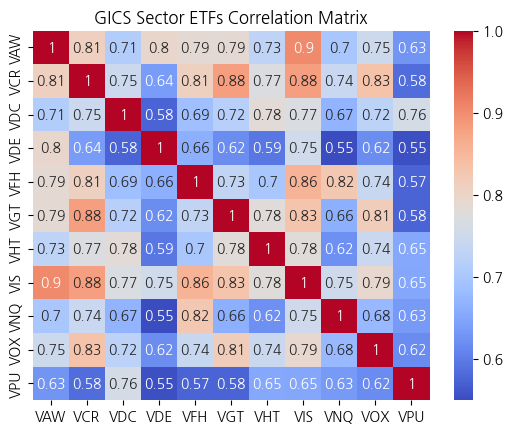

In [179]:

fig, ax = plt.subplots()
ax = sns.heatmap(df_return.corr(), cmap="coolwarm", annot=True)
ax.set_title("GICS Sector ETFs Correlation Matrix")
fig.figure.savefig("Correlation_Sectors.png", dpi=300)

In [180]:
df_mv

,return,risk
VDE,0.052916,0.099382
VAW,0.082053,0.063942
VIS,0.087228,0.051285
VCR,0.100332,0.051648
VDC,0.100588,0.022098
VHT,0.109122,0.032022
VFH,0.044736,0.085474
VGT,0.125951,0.053707
VOX,0.048168,0.045957
VPU,0.086112,0.036632


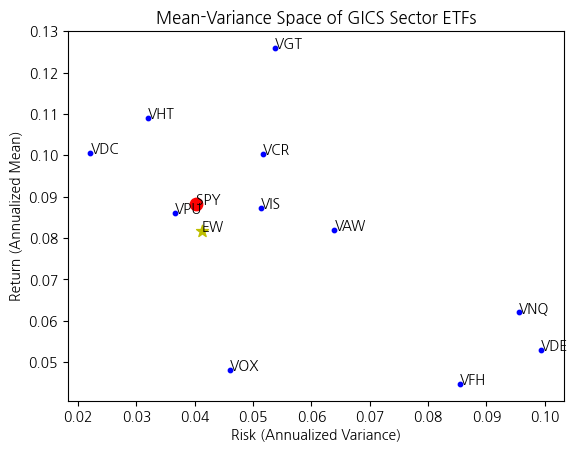

In [181]:

fig, ax = plt.subplots()
ax.set_title('Mean-Variance Space of GICS Sector ETFs')
ax.set_xlabel('Risk (Annualized Variance)')
ax.set_ylabel('Return (Annualized Mean)')

ax.scatter(df_mv['risk'].iloc[:-2], df_mv['return'].iloc[:-2],
           c='b', s=10)
ax.scatter(df_mv['risk']['SPY'], df_mv['return']['SPY'],
           c='r', s=80)
ax.scatter(df_mv['risk']['EW'], df_mv['return']['EW'],
           c='y', s=80, marker="*")
for i, v in enumerate(df_mv.index):
    # print(v)
    # print(df_mv['risk'].iloc[i])
    ax.annotate(v, (df_mv['risk'].iloc[i], df_mv['return'].iloc[i]))

# _ = fig.figure.savefig('Mean_Variance_Sectors.png', dpi=300)

### 3. Initialization
- Define Gene(Scalar) : A fraction of the total capital assigned to a stock by adressing them as weights. 

In [182]:
cagrs = np.array([CAGR(df_return[x]) for x in tickers])
cov = covariance(df_return)
# ra = 3 # inital set-up

# modify utility function to univariate for convenience
def fitness(weights, cagrs = cagrs, cov=cov):
  return pf_utility(cagrs, cov, weights)



In [183]:

weights = np.array([1/len(tickers)]*len(tickers))
print(f"EW Fitness: {fitness(weights):.4f}")

EW Fitness: 0.1564


### 3.1 Chromosome
- Define a Chromosome (1D array) : Set of genes, i,e fractions of total capital assigned to each stock. Set of weights. 

In [184]:
def generate_chromosome(n):
  '''
  Generate set of random numbers whose sum is equal to 1
  
  Parameters :
  n : int (number of assets)

  Returns :
  np.array (random weights)  
  '''
  chromosome = np.random.rand(n)
  return chromosome / np.sum(chromosome)

In [185]:
# example of chromosome
child = generate_chromosome(4)
print(child)

[0.05218941 0.13871642 0.25249039 0.55660378]


### 3.2 Inital population
- Generate a Inital population (2D array) : A set of randomyly generated chromosomes

In [187]:
# Generate initial population
n = len(tickers) # number of assets
pop_size = 100 #inital population

population = np.array([generate_chromosome(n) for _ in range(pop_size)])
print(population.shape)

print(population)



(100, 11)
[[1.62597575e-04 9.90684944e-02 1.40322342e-01 ... 1.47549751e-01
  1.09892926e-02 1.29531449e-01]
 [4.33267126e-02 5.53928341e-02 1.15066766e-01 ... 1.44867123e-01
  6.21713378e-02 1.11039201e-01]
 [6.11992138e-02 1.39775862e-01 1.26159455e-01 ... 1.04465986e-01
  1.04124427e-01 1.14535278e-01]
 ...
 [1.08277785e-01 1.35148633e-01 2.37863808e-02 ... 7.51664931e-02
  7.31551580e-02 5.33896626e-02]
 [1.97386012e-02 4.89576164e-02 1.27161454e-01 ... 1.49793077e-01
  1.76232703e-01 1.25448454e-01]
 [1.12695233e-01 1.45578248e-01 8.24359228e-02 ... 1.31792689e-01
  2.65068853e-02 1.18033772e-01]]


### 4. Elite Population
-  Select Elite Population : filters the elite chromosome which have highest sharp ratio, which were calculated in fitness function

In [188]:
def select_elite(population, frac=0.3):
  '''
  Select elite population
  
  Parameters:
  population : np.array (population of interest)
  frac : float (fraction of population to be considered as elite)
  
  Returns:
  np.array :  elite population
  '''
  population = sorted(population, key=lambda x: fitness(x), reverse=True)
  idx = int(np.floor(np.floor(len(population)*frac)))
  return population[:idx]


In [189]:
# example of elite population
elite = select_elite(population)
print(len(elite))
print(f"First Elite Fitness: {pf_utility(cagrs, cov,elite[0]):.2f}")
print(f"Last Elite Fitness: {pf_utility(cagrs, cov, elite[-1]):.2f}")

30
First Elite Fitness: 0.20
Last Elite Fitness: 0.17


In [190]:
[fitness(x) for x in population][:3]

[0.15636282299028056, 0.15311230523052333, 0.17598794127236253]

### 5. Mutation

In [194]:
def mutation(parent):
  '''
  Randomly chosen elements of a chromosome are swapped
  
  Parameters
  parent : np.array (parent chromosome)
  
  Returns:
  np.array (child chromosome)
  '''
  child = parent.copy()
  while True:
    # randomly choose 2 numbers in range of number of assets
    n = np.random.choice(range(parent.shape[0]), 2)
    # iterate until 2 choosen numbers are different
    if n[0] == n[1]:
      continue
    else:
      break
  child[n[0]], child[n[1]] = child[n[1]], child[n[0]]
  return child
  

In [195]:

# example of mutation
print("Before Mutation: ", population[0])
print("After Mutation: ", mutation(population[0]))

Before Mutation:  [0.0001626  0.09906849 0.14032234 0.10163773 0.09298555 0.09846929
 0.09995146 0.07933205 0.14754975 0.01098929 0.12953145]
After Mutation:  [0.0001626  0.09906849 0.14032234 0.10163773 0.07933205 0.09846929
 0.09995146 0.09298555 0.14754975 0.01098929 0.12953145]


## 6. Crossover
- The type of Crossover will use the fitness values of the two parents chromosomes to ascertain the direction of the search. It moves the from worst parent to best parent.

### Blended Crossover

In [41]:
def blended_crossover(parent1, parent2):
  '''
  Perform blended crossover
  
  Parameters
  parent1 : np.array (first parent)
  parent2 : np.array (second parent)
  
  Returns
  tuple(np.array, np.array) : two children
  
  '''
  beta = np.random.rand()
  
  if fitness(parent1) > fitness(parent2):
    child1 = parent1 +  beta * (parent1-parent2)
    child2 = parent2 - beta * (parent1-parent2)
  else:
    child1 = parent2 + beta * (parent2-parent1)
    child2 = parent1 - beta * (parent2-parent1)
  
  return child1, child2
    

In [200]:
# Example of blended crossover
print(f"Parent1 Fitness: {fitness(population[0]):.4f}")
print(population[0])
print("--------------------------------")
print(f"Parent2 Fitness: {fitness(population[1]):.4f}")
print(population[1])
print("--------------------------------")
for i, v in enumerate(blended_crossover(population[0], population[1])):
    print(f"Child{i+1} Fitness: {fitness(v):.4f}")
    print(v)
    print("--------------------------------")

Parent1 Fitness: 0.1564
[0.0001626  0.09906849 0.14032234 0.10163773 0.09298555 0.09846929
 0.09995146 0.07933205 0.14754975 0.01098929 0.12953145]
--------------------------------
Parent2 Fitness: 0.1531
[0.04332671 0.05539283 0.11506677 0.06890829 0.03263951 0.11608599
 0.12845122 0.12205102 0.14486712 0.06217134 0.1110392 ]
--------------------------------
Child1 Fitness: 0.1578
[-0.02272331  0.12222562  0.15371302  0.1189911   0.12498142  0.08912879
  0.08484069  0.05668217  0.1489721  -0.01614777  0.13933616]
--------------------------------
Child2 Fitness: 0.1511
[0.06621262 0.03223571 0.10167609 0.05155492 0.00064363 0.12542648
 0.14356199 0.14470091 0.14344478 0.0893084  0.10123449]
--------------------------------


### Arithemetic crossover
 

In [43]:
def arithmetic_crossover(parent1, parent2):
    '''
    Perform arithmetic crossover.
    
    Parameters
    -------
    parent1: np.array
        first parent
    parent2: np.array
        second parent
        
    Returns
    -------
    tuple(np.array, np.array)
        two children
    '''
    alpha = np.random.rand() # unif(0, 1)
    child1 = alpha * parent1 + (1-alpha) * parent2
    child2 = (1-alpha) * parent1 + alpha * parent2
    return child1, child2

In [202]:
# example of arithmetic crossover
print("--------------------------------")
print(f"Parent1 Fitness: {fitness(population[0]):.4f}")
print(population[0])
print("--------------------------------")
print(f"Parent2 Fitness: {fitness(population[1]):.4f}")
print(population[1])
print("--------------------------------")
for i, v in enumerate(arithmetic_crossover(population[0], population[1])):
    print(f"Child{i+1} Fitness: {fitness(v):.4f}")
    print(v)
    print("--------------------------------")

--------------------------------
Parent1 Fitness: 0.1564
[0.0001626  0.09906849 0.14032234 0.10163773 0.09298555 0.09846929
 0.09995146 0.07933205 0.14754975 0.01098929 0.12953145]
--------------------------------
Parent2 Fitness: 0.1531
[0.04332671 0.05539283 0.11506677 0.06890829 0.03263951 0.11608599
 0.12845122 0.12205102 0.14486712 0.06217134 0.1110392 ]
--------------------------------
Child1 Fitness: 0.1551
[0.01790515 0.08111567 0.12994107 0.08818434 0.06818038 0.10571061
 0.11166625 0.09689163 0.14644706 0.03202761 0.12193023]
--------------------------------
Child2 Fitness: 0.1545
[0.02558416 0.07334566 0.12544804 0.08236169 0.05744467 0.10884467
 0.11673643 0.10449144 0.14596981 0.04113302 0.11864042]
--------------------------------


### Uniform Crossover

In [45]:
def uniform_crossover(parent1, parent2):
    '''
    Perform uniform crossover.
    
    Parameters
    -------
    parent1: np.array
        first parent
    parent2: np.array
        second parent
        
    Returns
    -------
    tuple(np.array, np.array)
        two children
    '''
    child1 = []
    child2 = []
    for i in range(len(parent1)):
        r = np.random.rand() # unif(0, 1)
        if r > 0.5:
            child1.append(parent1[i])
            child2.append(parent2[i])
        else:
            child1.append(parent2[i])
            child2.append(parent1[i])
    
    return np.array(child1), np.array(child2)

In [203]:
# example of uniform crossover
print("--------------------------------")
print(f"Parent1 Fitness: {fitness(population[0]):.4f}")
print(population[0])
print("--------------------------------")
print(f"Parent2 Fitness: {fitness(population[1]):.4f}")
print(population[1])
print("--------------------------------")
for i, v in enumerate(uniform_crossover(population[0], population[1])):
    print(f"Child{i+1} Fitness: {fitness(v):.4f}")
    print(v)
    print("--------------------------------")

--------------------------------
Parent1 Fitness: 0.1564
[0.0001626  0.09906849 0.14032234 0.10163773 0.09298555 0.09846929
 0.09995146 0.07933205 0.14754975 0.01098929 0.12953145]
--------------------------------
Parent2 Fitness: 0.1531
[0.04332671 0.05539283 0.11506677 0.06890829 0.03263951 0.11608599
 0.12845122 0.12205102 0.14486712 0.06217134 0.1110392 ]
--------------------------------
Child1 Fitness: 0.1880
[0.0001626  0.09906849 0.14032234 0.10163773 0.09298555 0.09846929
 0.09995146 0.12205102 0.14754975 0.06217134 0.12953145]
--------------------------------
Child2 Fitness: 0.1140
[0.04332671 0.05539283 0.11506677 0.06890829 0.03263951 0.11608599
 0.12845122 0.07933205 0.14486712 0.01098929 0.1110392 ]
--------------------------------


## 7. Next generation

In [204]:

def next_generation(pop_size, elite, crossover, frac=0.3):
    '''
    Perform mutation and crossover and build a new generation of chromosomes.
    
    Parameters
    -------
    pop_size: int
        size of population
    elite: np.array
        elite population
    crossover: function
        crossover method
    frac: float
        fraction of final stages
    
    Returns
    -------
    np.array
        new generation of chromosomes
    '''
    new_population = []
    elite_range = range(len(elite))

    while len(new_population) < pop_size:
        # choose randomly between crossover and mutation
        if len(new_population) > (1-frac) * pop_size:
            # mutation frequency decreased in final stages
            # r.v. assgining 0 for crossover 1 for mutation
            co_or_mutate = np.random.choice([0,1], p=[0.9,0.1])
        else:
            co_or_mutate = np.random.choice([0,1], p=[0.6, 0.4])
        
        if co_or_mutate == 1:
            # perform mutation
            idx = np.random.choice(elite_range)
            new_population.append(mutation(elite[idx]))
        else:
            # perform crossover
            while True:
                # iterate until all elements are positive
                p1_idx, p2_idx = np.random.choice(elite_range, 2)
                c1, c2 = crossover(elite[p1_idx], elite[p2_idx])
                if min(np.min(c1), np.min(c2)) > 0:
                    # check whether all elements are positive
                    break
                else:
                    continue
            new_population.extend([c1, c2])
    return np.array(new_population)[:100] # do not allow larger than 100

In [205]:
# example of next generation
print(next_generation(pop_size, elite, blended_crossover).shape)

(100, 11)


## 8. Optimization by iteration 

#### Blended crossover

In [237]:
# constant parameters
cagrs = np.array([CAGR(df_return[x]) for x in tickers])
cov = covariance(df_return)

# modify utility function to univariate for convenience
def fitness(weights, cagrs=cagrs, cov=cov ):
    return pf_utility(cagrs, cov, weights)

# initial parameters
n = len(tickers)
pop_size = 100

# initial population
population = np.array([generate_chromosome(n) for _ in range(pop_size)])

# select elite populatioin
elite = select_elite(population)

iterations = 50
result = dict()

# iterate for loop
cross_over_str = "Blended Crossover"
cross_over_func = blended_crossover
for iteration in tqdm(range(iterations)):
    population = next_generation(pop_size, elite, cross_over_func)
    elite = select_elite(population)
    result[iteration] = {'return':pf_CAGR(cagrs, elite[0]),
                         'risk':pf_var(cov, elite[0]),
                         'utility':fitness(elite[0])}

df_result = pd.DataFrame(result).T

100%|██████████| 50/50 [00:00<00:00, 164.47it/s]


In [238]:
print("<Optimization Result>")
print(f"Return (Mean): \t\t{df_result['return'][iterations-1]:.4f}")
print(f"Risk (Variance): \t{df_result['risk'][iterations-1]:.4f}")
print(f"fitness (Sharp): \t{df_result['utility'][iterations-1]:.4f}")
print("")
print("<>")
for i, v in zip(tickers, elite[0]):
    print(f"{i:<4} {('('+universe[i]+')'):<25}:\t {v:.4f}")

<Optimization Result>
Return (Mean): 		0.1139
Risk (Variance): 	0.0429
fitness (Sharp): 	0.3085

<>
VDE  (Energy)                 :	 0.0073
VAW  (Materials)              :	 0.0007
VIS  (Industrial)             :	 0.0997
VCR  (Consumer&Discretionary) :	 0.0176
VDC  (Consumer Staples)       :	 0.0008
VHT  (Health Care)            :	 0.1738
VFH  (Financials)             :	 0.0069
VGT  (Information Technology) :	 0.6060
VOX  (Communication Services) :	 0.0044
VPU  (Utilities Sector)       :	 0.0826
VNQ  (Real Estate)            :	 0.0001


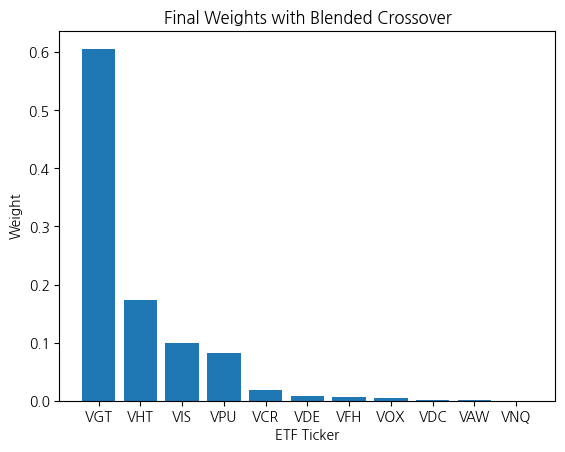

In [239]:
# plot result weightings
fig, ax = plt.subplots()
ax.set_title(f'Final Weights with {cross_over_str}')
ax.set_xlabel('ETF Ticker')
ax.set_ylabel('Weight')

ax.bar(sorted(tickers, key=lambda x: elite[0][tickers.index(x)], reverse=True),
       sorted(elite[0], reverse=True))

_ = fig.figure.savefig('Final_Weights_Blended_Crossover.png', dpi=300)

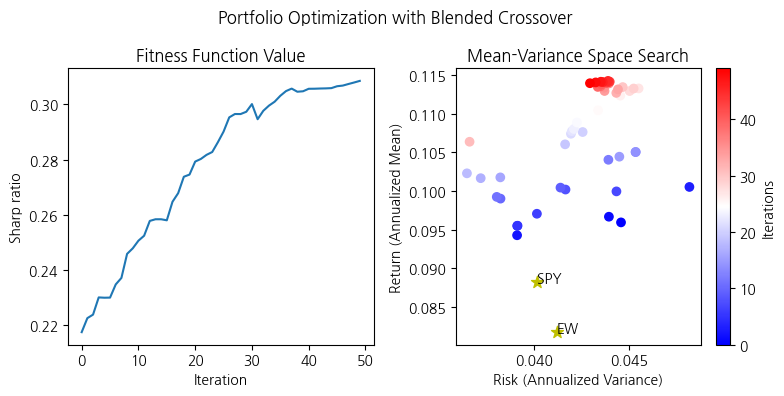

In [240]:
# plot optimization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4))
fig.suptitle(f'Portfolio Optimization with {cross_over_str}')

# fitness plot
ax1.set_title('Fitness Function Value')
ax1.plot(df_result.index, df_result['utility'])
ax1.set_xlabel('Iteration')
ax1.set_ylabel('Sharp ratio')

# mean variance plot
ax2.set_title('Mean-Variance Space Search')
ax2.scatter(df_result['risk'], df_result['return'],
            c=df_result.index, cmap='bwr')
ax2.set_xlabel('Risk (Annualized Variance)')
ax2.set_ylabel('Return (Annualized Mean)')

# benchmark
ax2.scatter(df_mv['risk']['SPY'], df_mv['return']['SPY'],
            c='y', s=80, marker="*")
ax2.scatter(df_mv['risk']['EW'], df_mv['return']['EW'],
            c='y', s=80, marker="*")
ax2.annotate("SPY", (df_mv['risk']['SPY'], df_mv['return']['SPY']))
ax2.annotate("EW", (df_mv['risk']['EW'], df_mv['return']['EW']))

# cmap
norm = mpl.colors.Normalize(vmin=min(df_result.index),
                            vmax=max(df_result.index))
colormapping = cm.ScalarMappable(norm=norm, cmap=cm.bwr)
cbar = fig.colorbar(colormapping, ax=plt.gca())
cbar.set_label('Iterations')

fig.tight_layout()
_ = fig.figure.savefig('Optimization_Blended_Crossover.png', dpi=300)

#### arithemetic crossover

In [247]:
# constant parameters
cagrs = np.array([CAGR(df_return[x]) for x in tickers])
cov = covariance(df_return)
ra = 3 # intial setup

# modify utility function to univariate for convenience
def fitness(weights, cagrs=cagrs, cov=cov):
    return pf_utility(cagrs, cov, weights)

# initial parameters
n = len(tickers)
pop_size = 100

# initial population
population = np.array([generate_chromosome(n) for _ in range(pop_size)])

# select elite populatioin
elite = select_elite(population)

iterations = 50
result = dict()

# iterate for loop
cross_over_str = "Arithmetic Crossover"
cross_over_func = arithmetic_crossover
for iteration in tqdm(range(iterations)):
    population = next_generation(pop_size, elite, cross_over_func)
    elite = select_elite(population)
    result[iteration] = {'return':pf_CAGR(cagrs, elite[0]),
                         'risk':pf_var(cov, elite[0]),
                         'utility':fitness(elite[0])}

df_result = pd.DataFrame(result).T

100%|██████████| 50/50 [00:00<00:00, 373.13it/s]


In [248]:
print("<Optimization Result>")
print(f"Return (Mean): \t\t{df_result['return'][iterations-1]:.4f}")
print(f"Risk (Variance): \t{df_result['risk'][iterations-1]:.4f}")
print(f"fitness (Sharp): \t{df_result['utility'][iterations-1]:.4f}")
print("")
print("<Optimal Solution weights>")
for i, v in zip(tickers, elite[0]):
    print(f"{i:<4} {('('+universe[i]+')'):<25}:\t {v:.4f}")

<Optimization Result>
Return (Mean): 		0.0945
Risk (Variance): 	0.0399
fitness (Sharp): 	0.2225

<Optimal Solution weights>
VDE  (Energy)                 :	 0.0404
VAW  (Materials)              :	 0.0645
VIS  (Industrial)             :	 0.1499
VCR  (Consumer&Discretionary) :	 0.1068
VDC  (Consumer Staples)       :	 0.0908
VHT  (Health Care)            :	 0.1520
VFH  (Financials)             :	 0.0420
VGT  (Information Technology) :	 0.1773
VOX  (Communication Services) :	 0.0160
VPU  (Utilities Sector)       :	 0.1079
VNQ  (Real Estate)            :	 0.0524


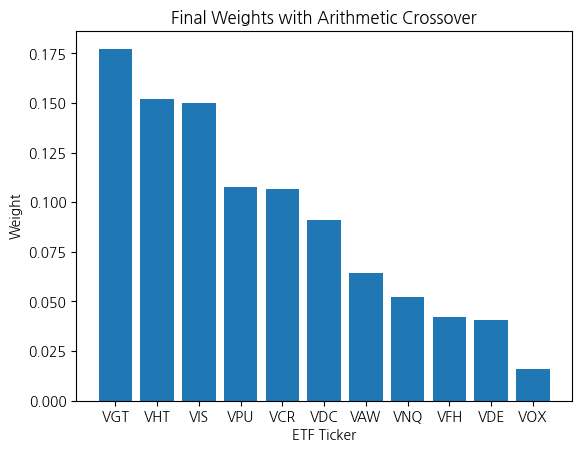

In [249]:
# plot result weightings
fig, ax = plt.subplots()
ax.set_title(f'Final Weights with {cross_over_str}')
ax.set_xlabel('ETF Ticker')
ax.set_ylabel('Weight')

ax.bar(sorted(tickers, key=lambda x: elite[0][tickers.index(x)], reverse=True),
       sorted(elite[0], reverse=True))

_ = fig.figure.savefig('Final_Weights_Arithmetic_Crossover.png', dpi=300)

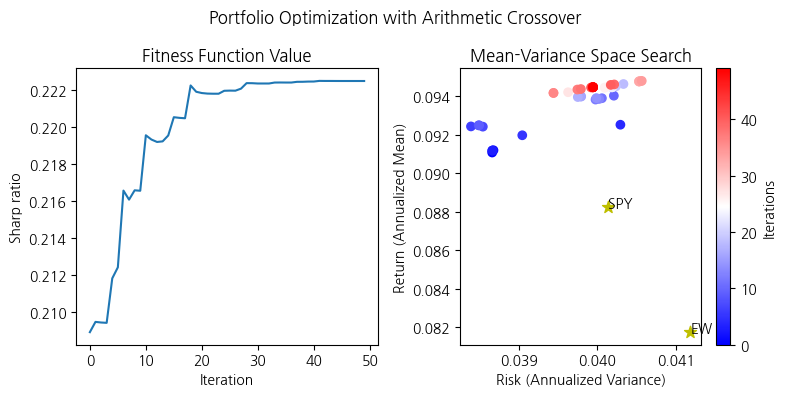

In [250]:
# plot optimization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4))
fig.suptitle(f'Portfolio Optimization with {cross_over_str}')

# fitness plot
ax1.set_title('Fitness Function Value')
ax1.plot(df_result.index, df_result['utility'])
ax1.set_xlabel('Iteration')
ax1.set_ylabel('Sharp ratio')

# mean variance plot
ax2.set_title('Mean-Variance Space Search')
ax2.scatter(df_result['risk'], df_result['return'],
            c=df_result.index, cmap='bwr')
ax2.set_xlabel('Risk (Annualized Variance)')
ax2.set_ylabel('Return (Annualized Mean)')

# benchmark
ax2.scatter(df_mv['risk']['SPY'], df_mv['return']['SPY'],
            c='y', s=80, marker="*")
ax2.scatter(df_mv['risk']['EW'], df_mv['return']['EW'],
            c='y', s=80, marker="*")
ax2.annotate("SPY", (df_mv['risk']['SPY'], df_mv['return']['SPY']))
ax2.annotate("EW", (df_mv['risk']['EW'], df_mv['return']['EW']))

# cmap
norm = mpl.colors.Normalize(vmin=min(df_result.index),
                            vmax=max(df_result.index))
colormapping = cm.ScalarMappable(norm=norm, cmap=cm.bwr)
cbar = fig.colorbar(colormapping, ax=plt.gca())
cbar.set_label('Iterations')

fig.tight_layout()
_ = fig.figure.savefig('Optimization_Arithmetic_Crossover.png', dpi=300)

#### Uniform Crossover

In [251]:
# constant parameters
cagrs = np.array([CAGR(df_return[x]) for x in tickers])
cov = covariance(df_return)
ra = 3 # intial setup

# modify utility function to univariate for convenience
def fitness(weights, cagrs=cagrs, cov=cov):
    return pf_utility(cagrs, cov, weights)

# initial parameters
n = len(tickers)
pop_size = 100

# initial population
population = np.array([generate_chromosome(n) for _ in range(pop_size)])

# select elite populatioin
elite = select_elite(population)

iterations = 50
result = dict()

# iterate for loop
cross_over_str = "Uniform Crossover"
cross_over_func = uniform_crossover
for iteration in tqdm(range(iterations)):
    population = next_generation(pop_size, elite, cross_over_func)
    elite = select_elite(population)
    result[iteration] = {'return':pf_CAGR(cagrs, elite[0]),
                         'risk':pf_var(cov, elite[0]),
                         'utility':fitness(elite[0])}

df_result = pd.DataFrame(result).T

  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 50/50 [00:00<00:00, 349.66it/s]


In [252]:
print("<Optimization Result>")
print(f"Return (Mean): \t\t{df_result['return'][iterations-1]:.4f}")
print(f"Risk (Variance): \t{df_result['risk'][iterations-1]:.4f}")
print(f"fitness (Sharp): \t{df_result['utility'][iterations-1]:.4f}")
print("")
print("<Optimal Solution weights>")
for i, v in zip(tickers, elite[0]):
    print(f"{i:<4} {('('+universe[i]+')'):<25}:\t {v:.4f}")

<Optimization Result>
Return (Mean): 		0.1615
Risk (Variance): 	0.1197
fitness (Sharp): 	0.3222

<Optimal Solution weights>
VDE  (Energy)                 :	 0.0090
VAW  (Materials)              :	 0.2071
VIS  (Industrial)             :	 0.2156
VCR  (Consumer&Discretionary) :	 0.2071
VDC  (Consumer Staples)       :	 0.2071
VHT  (Health Care)            :	 0.2156
VFH  (Financials)             :	 0.0448
VGT  (Information Technology) :	 0.2156
VOX  (Communication Services) :	 0.0057
VPU  (Utilities Sector)       :	 0.2071
VNQ  (Real Estate)            :	 0.2071


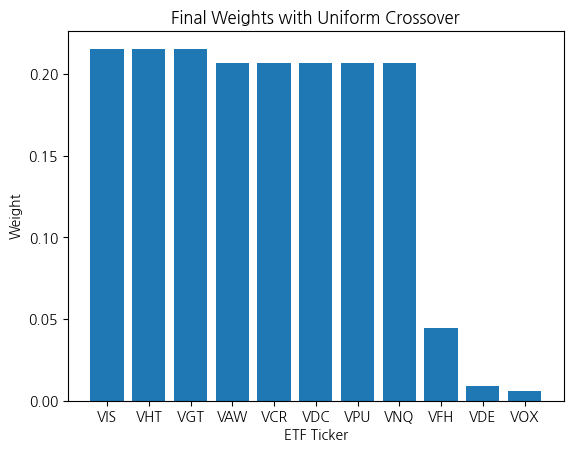

In [253]:
# plot result weightings
fig, ax = plt.subplots()
ax.set_title(f'Final Weights with {cross_over_str}')
ax.set_xlabel('ETF Ticker')
ax.set_ylabel('Weight')

ax.bar(sorted(tickers, key=lambda x: elite[0][tickers.index(x)], reverse=True),
       sorted(elite[0], reverse=True))

_ = fig.figure.savefig('Final_Weights_Uniform_Crossover.png', dpi=300)

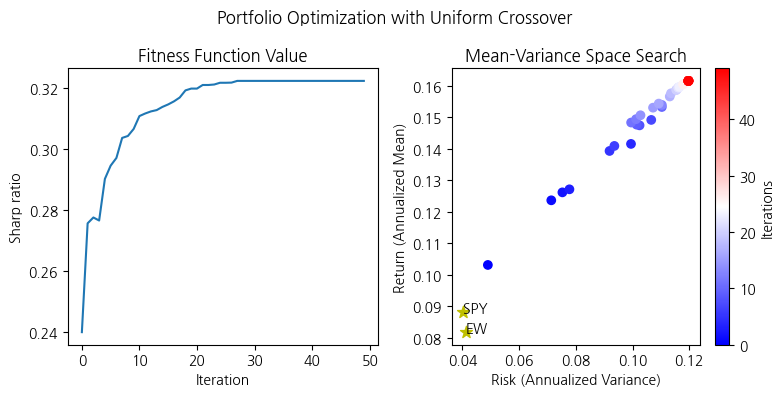

In [254]:

# plot optimization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4))
fig.suptitle(f'Portfolio Optimization with {cross_over_str}')

# fitness plot
ax1.set_title('Fitness Function Value')
ax1.plot(df_result.index, df_result['utility'])
ax1.set_xlabel('Iteration')
ax1.set_ylabel('Sharp ratio')

# mean variance plot
ax2.set_title('Mean-Variance Space Search')
ax2.scatter(df_result['risk'], df_result['return'],
            c=df_result.index, cmap='bwr')
ax2.set_xlabel('Risk (Annualized Variance)')
ax2.set_ylabel('Return (Annualized Mean)')

# benchmark
ax2.scatter(df_mv['risk']['SPY'], df_mv['return']['SPY'],
            c='y', s=80, marker="*")
ax2.scatter(df_mv['risk']['EW'], df_mv['return']['EW'],
            c='y', s=80, marker="*")
ax2.annotate("SPY", (df_mv['risk']['SPY'], df_mv['return']['SPY']))
ax2.annotate("EW", (df_mv['risk']['EW'], df_mv['return']['EW']))

# cmap
norm = mpl.colors.Normalize(vmin=min(df_result.index),
                            vmax=max(df_result.index))
colormapping = cm.ScalarMappable(norm=norm, cmap=cm.bwr)
cbar = fig.colorbar(colormapping, ax=plt.gca())
cbar.set_label('Iterations')

fig.tight_layout()
_ = fig.figure.savefig('Optimization_Uniform_Crossover.png', dpi=300)